# Capstone Project: Dialogue classification

This project tries to predict the character that speaks a dialogue line in the iconic comedy show Seinfeld (NBC, 1989-1998).

The notebook is divided into the following steps:
* [Step 0](#step0): Import of dataset
* [Step 1](#step1): Cleaning and preprocessing of data
* [Step 2](#step2): Data exploration
* [Step 3](#step3): Training of classifiers with scikit-learn
* [Step 4](#step4): Creation and training of artificial neural networks (ANN)
* [Step 5](#step5): Confusion map of best classifier




<a id='step0'></a>
## Step 0: Import of dataset
 
The data was scraped from seinology.com using the code form a GitHub repository (https://github.com/amanthedorkknight/the-seinfeld-chronicles ).

In [1]:
# load all necessary libraries at first
import numpy as np
#from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files       
#from keras.utils import np_utils

# load the dataset
data = pd.read_csv("Seinfeld_dialogue_scripts.csv")
# remove all columns except for Character and Dialogue
#data = data.iloc[:,1:3]

print(data.head())
print(data.iloc[:,1:3].shape)
print(data.iloc[:,1:3].describe())

   Unnamed: 0 Character                                           Dialogue  \
0           0     JERRY  Do you know what this is all about? Do you kno...   
1           1     JERRY  (pointing at Georges shirt) See, to me, that b...   
2           2    GEORGE                                   Are you through?   
3           3     JERRY             You do of course try on, when you buy?   
4           4    GEORGE  Yes, it was purple, I liked it, I dont actuall...   

   EpisodeNo    SEID  Season  
0        1.0  S01E01     1.0  
1        1.0  S01E01     1.0  
2        1.0  S01E01     1.0  
3        1.0  S01E01     1.0  
4        1.0  S01E01     1.0  
(54616, 2)
       Character Dialogue
count      54616    54606
unique      1639    48792
top        JERRY    Yeah.
freq       14786      413


### Some rows in the data contain setting information and stage directions

In [2]:
#examples of lines with setting information
print(data[data['Character'] == '[Setting'].head())
print(data[data['Character'] == '[Setting'].describe())
#examples of lines with stage directions
print(data[data.Character.str.startswith('(')==True].head())
print(data[data.Character.str.startswith('(')==True].describe())

      Unnamed: 0 Character            Dialogue  EpisodeNo    SEID  Season
3172        3172  [Setting         Night club]        8.0  S02E08     2.0
3174        3174  [Setting  Jerry's apartment]        8.0  S02E08     2.0
3176        3176  [Setting    Jerry's bedroom]        8.0  S02E08     2.0
3177        3177  [Setting        Coffee shop]        8.0  S02E08     2.0
3210        3210  [Setting      Hospital room]        8.0  S02E08     2.0
         Unnamed: 0   EpisodeNo      Season
count    293.000000  293.000000  293.000000
mean   33547.825939   11.453925    6.529010
std    16687.103425    5.285230    2.386465
min     3172.000000    2.000000    2.000000
25%    18872.000000    8.000000    5.000000
50%    39840.000000   10.000000    7.000000
75%    49699.000000   16.000000    9.000000
max    52908.000000   23.000000    9.000000
      Unnamed: 0                                          Character  \
52            52  (George shows his note-block to Jerry; it says...   
4304        4304  

### Show examples of regular dialogue lines
Some lines include spelling mistakes and sounds that the characters make

In [40]:
from tabulate import tabulate

#print specific dialogue lines
print(tabulate(data.iloc[[16,17, 308, 616, 5063, 575, 3174],:], headers='keys', tablefmt='presto'))


      | Character   | Dialogue
------+-------------+------------------------------------------------------------------------------------------------------------------------------------------
   16 | JERRY       | I told you about Laura, the girl I met in Michigan?
   17 | GEORGE      | No, you didnt!
  312 | ELAINE      | Uh-huh...
  621 | JERRY       | Yeah, and?
 5133 | HELEN       | He talks about it all the time. Every time he takes it out he goes on and on about how it writes upside down, how the astronauts use it.
  580 | ELAINE      | No, Im staying here for the weekend. Im getting a break from my roommate.
 3195 | GEORGE      | Tightness..


 <a id='step1'></a>
## Step 1: Cleaning & preprocessing of data

In [2]:
#reduce to just character and dialogue
data = data.iloc[:,1:3]

data = data[data['Character'] != '[Setting'] #drop all rows with setting information
data = data[data.Character.str.startswith('[') == False] # removes remaining rows with setting information

data = data[data.Character.str.startswith('(')==False] # removes rows with stage directions

data.Dialogue = data.Dialogue.str.replace('\(.*\)', '') #remove stage directions from dialogues
data.Character = data.Character.str.replace(' *\(.*\)', '') #remove stage directions from characters

#merge all lines from Uncle Leo into one Class
data.Character = data.Character.str.replace('^LEO$', 'UNCLE LEO') 

# convert 'MAN' , 'WOMAN' to 'Other'
data.Character = data.Character.str.replace('^MAN$', 'Other')
data.Character = data.Character.str.replace('^WOMAN$', 'Other')

label_counts = data['Character'].value_counts() #this is a Series

# delete everything with value_count == 1
data = data[~data['Character'].isin(label_counts[label_counts.values == 1].index)] #remove all rows with labels tha
label_counts = data['Character'].value_counts() #update label counts

#convert rows of non-recurring characters to 'Other'
data.loc[data['Character'].isin(label_counts[label_counts.values < 100].index), 'Character'] = 'Other'

 <a id='step2'></a>
 ## Step 2: Data exploration

(53795, 2)


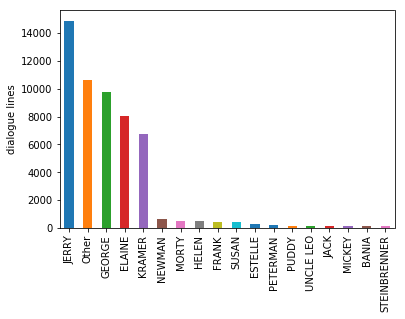

In [5]:
print(data.shape)

fig, ax = plt.subplots()
data['Character'].value_counts().plot(ax=ax, kind='bar')
plt.ylabel('dialogue lines')
plt.show()

Fig 1 shows distribution of class labels...

### Manually convert dialogue lines to vectors of words and calculate statistics on word length and sentence length for all characters
This is only done for exploratory reasons.

In [32]:
import string, math
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS

#remove punctuation
table = str.maketrans({key: " " for key in string.punctuation})

new_data = []
#loop over all dialogue lines
for j in range(0, data['Dialogue'].size):
    
    #split lines into list of words
    splitted_line = str(data['Dialogue'].iloc[j]).translate(table).lower().split()

    #calculate sentence length/word length statistics
    num_words = len(splitted_line)
    
    if num_words != 0:
        
        wordlen = []
        #loop over all words in a dialogue line
        for w in splitted_line:
            wordlen.append(len(w)) #add word length to list
        
        #calculate descriptive statistics of word length
        wlen_mean = np.mean(np.array(wordlen))
        wlen_se = np.std(np.array(wordlen))/math.sqrt(len(wordlen))
        wlen_max = np.amax(np.array(wordlen))
    else:
        #fail safe
        num_words = np.nan
        wlen_mean = np.nan
        wlen_se = np.nan
        wlen_max = np.nan
        
    
    new_data.append([num_words, wlen_mean, wlen_se, wlen_max])
    
    #remove stop words
    '''tbdel = []
    for i in range(0, len(splitted_line)):
        for stopw in stop_words:
            if splitted_line[i] == stopw:
                #print("delete this")
                tbdel.append(i)

    print("indeces to be deleted \n", tbdel)
    print("whole array \n", np.array(splitted_line))
    print("array of items to be deleted \n",np.array(splitted_line)[tbdel])
    print("array after deletion \n", np.delete(np.array(splitted_line), tbdel))'''
    
#convert to pandas DataFrame
new_df = pd.DataFrame(new_data,columns=['num_words','wlen_mean', 'wlen_se', 'wlen_max'])
del(new_data)
print(new_df.describe())

          num_words     wlen_mean       wlen_se      wlen_max
count  53499.000000  53499.000000  53499.000000  53499.000000
mean       9.695153      3.726126      0.544564      6.476813
std       11.209688      0.975758      0.366671      2.272675
min        1.000000      1.000000      0.000000      1.000000
25%        4.000000      3.157895      0.353151      5.000000
50%        7.000000      3.625000      0.496904      6.000000
75%       12.000000      4.000000      0.707107      8.000000
max      374.000000     21.000000      4.596194     24.000000


In [3]:
class_names = data['Character'].unique()

In [34]:
# reduce data from 'new_data' this to summary information
summary = []

#loop over all classes/characters
for char in class_names:

    indeces = list(np.where(data['Character'] == char)[0])
    #calculate statistics to dialogue lengths/word lengths
    summary.append([char, new_df.iloc[indeces]['num_words'].mean(), new_df.iloc[indeces]['num_words'].max(),
                   new_df.iloc[indeces]['num_words'].sem(), new_df.iloc[indeces]['wlen_mean'].mean(),
                   new_df.iloc[indeces]['wlen_mean'].max(), new_df.iloc[indeces]['wlen_max'].mean(),
                   new_df.iloc[indeces]['wlen_max'].max()])

#save information in pandas DataFrame
summary_df = pd.DataFrame(summary, columns=['Character', 'senlen_mean', 'senlen_max', 'senlen_sem', 'wlen_mean_mean',
                                           'wlen_mean_max', 'wlen_max_mean', 'wlen_max_max'])

#print(tabulate(summary_df, headers='keys', tablefmt='presto'))
print(summary_df)

       Character  senlen_mean  senlen_max  senlen_sem  wlen_mean_mean  \
0          JERRY     9.764405       374.0    0.111839        3.722065   
1         GEORGE    10.595699       153.0    0.111291        3.722478   
2          Other     9.068835       251.0    0.098520        3.801284   
3         KRAMER    10.043908       112.0    0.122537        3.683094   
4         ELAINE     8.999751       202.0    0.104802        3.656836   
5          MORTY     9.413861        44.0    0.331516        3.755995   
6          HELEN     7.162791        43.0    0.239635        3.790824   
7      UNCLE LEO     9.770833        51.0    0.746770        3.914044   
8         NEWMAN    10.778295        77.0    0.442971        3.857244   
9           JACK     9.008065        47.0    0.709190        3.544031   
10         SUSAN     7.321053        47.0    0.315401        3.640705   
11       ESTELLE     8.164336        46.0    0.362134        3.783974   
12         FRANK    10.670507        79.0    0.4124

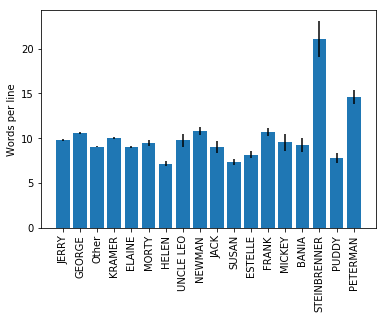

"#version 2\nfig, ax = plt.subplots()\nplt.ylabel('Words per line')\nsummary_df['senlen_mean'].plot(ax=ax, kind='bar', yerr=summary_df['senlen_sem'])\nplt.xticks(indeces, summary_df['Character'],rotation=90)\nplt.show()"

In [36]:
# plot words per line(mean + se) for all characters

#version 1
indeces = np.arange(summary_df['Character'].size)
plt.ylabel('Words per line')
plt.bar(indeces, summary_df['senlen_mean'], yerr=summary_df['senlen_sem'])
plt.xticks(indeces, summary_df['Character'],rotation=90)
plt.show()

'''#version 2
fig, ax = plt.subplots()
plt.ylabel('Words per line')
summary_df['senlen_mean'].plot(ax=ax, kind='bar', yerr=summary_df['senlen_sem'])
plt.xticks(indeces, summary_df['Character'],rotation=90)
plt.show()'''

 <a id='step3'></a>
## Step 3: Training of classifiers with scikit-learn
....
...

In [4]:
# load all necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from nltk.stem import SnowballStemmer

from sklearn.preprocessing import Imputer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from time import time

from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedShuffleSplit
#import winsound

C:\Users\Momo\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
# define function to run treatments and train different classifiers
def run_treatment(labels, features, treatment):
    trt_res = []
    
    if treatment[1] == True:
        #remove rows with other
        indeces = list(np.where(labels != 'Other')[0])
        
        labels = labels.iloc[indeces]
        features = features.iloc[indeces]
        
        features.index = range(len(features)) #set new indeces
        labels.index = range(len(labels))
        
        #print(labels.size)
        
    if treatment[2] == True:
        stop_words = 'english'
    else:
        stop_words = None
    
    #generate transformed feature space
    if treatment[4] == False:
        #no tfidf
        if treatment[3] == False:
        # convert dialogues to word count vectors (BOW approach)
            vectorizer = CountVectorizer(ngram_range=treatment[0], stop_words=stop_words)
        else:
            english_stemmer = SnowballStemmer('english')

            class StemmedCountVectorizer(CountVectorizer):
                def build_analyzer(self):
                    analyzer = super(StemmedCountVectorizer, self).build_analyzer()
                    return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

            vectorizer = StemmedCountVectorizer(analyzer="word", stop_words=stop_words, ngram_range=treatment[0])
    
    else:
        #do use tfidf
        if treatment[3] == False:
        # convert dialogues to word count vectors (BOW approach)
            vectorizer = TfidfVectorizer(ngram_range=treatment[0], stop_words=stop_words)
        else:
            english_stemmer = SnowballStemmer('english')

            class StemmedTfidfVectorizer(TfidfVectorizer):
                def build_analyzer(self):
                    analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
                    return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])
    
            vectorizer = StemmedTfidfVectorizer(analyzer="word", stop_words=stop_words, ngram_range=treatment[0])
        
    
    features_bow = vectorizer.fit_transform(features.values.astype('U')) #transformed features/BOW
    
    '''# shuffle and convert into train validation and testing set
    #X_train, X_test, y_train, y_test = train_test_split(features_bow, 
    #                                                    labels, 
    #                                                    test_size = 0.2, 
    #                                                    random_state = 11)
    '''
    
    # do a stratified split, X_test, y_test are holdout data
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=11)
    
    for train_index, test_index in sss.split(np.zeros(labels.size), labels):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = features_bow[train_index], features_bow[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    
    
    # set up different parameter lists for the different classifiers
    est_params = [
                [MultinomialNB(), {'alpha':[1.0, 0.85, 0.7]}],
                [LinearSVC(random_state=1),  {'C':[1, 10]}],
                 [RandomForestClassifier(random_state=1), 
                  #{'n_estimators':[150, 250],'min_samples_split':[60, 90]
                  {'n_estimators':[250],'min_samples_split':[90]
                  # , 'min_samples_leaf':[1, 5, 20]
                  }]]
    
    #loop through list of estimators
    for i in range(len(est_params)):
        #start_time = time()
        #use gridSearch to optimize hyper-parameter values
        clf = GridSearchCV(estimator=est_params[i][0], param_grid=est_params[i][1], cv=3, n_jobs=2,
                       scoring='accuracy')
        clf.fit(X_train, y_train)
        #end_time = time()
        #print("this took", end_time-start_time)
        
        clf_name = est_params[i][0].__class__.__name__ #name of classifier
        best_parameters = clf.best_params_ #best combination of parameters found during grid search
        train_acc = clf.best_score_ #mean cross validated accuracy of classifier with best parameters
        
        y_true, y_pred = y_test, clf.predict(X_test) #use holdout data
        test_acc = accuracy_score(y_true, y_pred)
        
        trt_res.append(treatment + [clf_name, best_parameters, train_acc, test_acc])
        #print(trt_res)
                  
    
    #is everything automatically removed with the end of this function call?
    return(trt_res)

In [ ]:
ngrams = [(1,1), (1,2), (2,2)]
remove_other = [False, True]
remove_stopw = [False, True]
stem = [False, True]
tfidf = [False, True]

treatments = [[ngrams[0], remove_other[0], remove_stopw[0], stem[0], tfidf[0]],
[ngrams[0], remove_other[0], remove_stopw[1], stem[0], tfidf[0]],
[ngrams[0], remove_other[0], remove_stopw[1], stem[1], tfidf[0]],
[ngrams[0], remove_other[0], remove_stopw[1], stem[1], tfidf[1]],
[ngrams[0], remove_other[1], remove_stopw[0], stem[0], tfidf[0]],
[ngrams[0], remove_other[1], remove_stopw[1], stem[0], tfidf[0]],
[ngrams[0], remove_other[1], remove_stopw[1], stem[1], tfidf[0]],
[ngrams[0], remove_other[1], remove_stopw[1], stem[1], tfidf[1]],
[ngrams[1], remove_other[0], remove_stopw[0], stem[0], tfidf[0]],
[ngrams[1], remove_other[0], remove_stopw[1], stem[0], tfidf[0]],
[ngrams[1], remove_other[0], remove_stopw[1], stem[1], tfidf[0]],
[ngrams[1], remove_other[0], remove_stopw[1], stem[1], tfidf[1]],
[ngrams[1], remove_other[1], remove_stopw[0], stem[0], tfidf[0]],
[ngrams[1], remove_other[1], remove_stopw[1], stem[0], tfidf[0]],
[ngrams[1], remove_other[1], remove_stopw[1], stem[1], tfidf[0]],
[ngrams[1], remove_other[1], remove_stopw[1], stem[1], tfidf[1]],
[ngrams[2], remove_other[0], remove_stopw[0], stem[0], tfidf[0]],
[ngrams[2], remove_other[0], remove_stopw[1], stem[0], tfidf[0]],
[ngrams[2], remove_other[0], remove_stopw[1], stem[1], tfidf[0]],
[ngrams[2], remove_other[0], remove_stopw[1], stem[1], tfidf[1]],
[ngrams[2], remove_other[1], remove_stopw[0], stem[0], tfidf[0]],
[ngrams[2], remove_other[1], remove_stopw[1], stem[0], tfidf[0]],
[ngrams[2], remove_other[1], remove_stopw[1], stem[1], tfidf[0]],
[ngrams[2], remove_other[1], remove_stopw[1], stem[1], tfidf[1]]]

#print(len(treatments))
#print(treatments)

In [32]:
#print(treatments[4])

results = []
counter = 0

#parameters for winsound beep (alert when operation is finished)
#duration = 1000  # millisecond
#freq = 640  # Hz

#loop of treatments
for trt in treatments:
    counter += 1
    start_time = time()
    #save results of that treatment
    tmpres = run_treatment(data['Character'], data['Dialogue'], trt)
    results.append(tmpres)
    end_time = time()
    #winsound.Beep(int(freq+100), int(duration/3))
    print("Treatment", counter, "took", end_time-start_time, "s")
    print(tmpres)

#winsound.Beep(freq, duration)

'''
print(data['Character'].size)

print(data[data['Character']=='Other'].size)


#indeces = list(np.where(data['Character'] == char)[0])
indeces = list(np.where(data['Character'] == 'Other')[0])
print(len(indeces))

print(indeces)

#print(type(labels))#yes it is a series :)
#print(labels[~labels[labels.iloc[indeces]]].size)
#newlabels = labels.drop(index=[indeces],axis=0)
#print(newlabels.size)
'''

Treatment 1 took 731.1254098415375 s
[[(1, 1), False, False, False, False, 'MultinomialNB', {'alpha': 0.85}, 0.32477460730551166, 0.32679617064782973], [(1, 1), False, False, False, False, 'LinearSVC', {'C': 1}, 0.30286271958360445, 0.3097871549400502], [(1, 1), False, False, False, False, 'RandomForestClassifier', {'n_estimators': 250, 'min_samples_split': 90}, 0.3197555534901013, 0.31870991727855746]]
Treatment 2 took 1006.320481300354 s
[[(1, 1), False, True, False, False, 'MultinomialNB', {'alpha': 0.7}, 0.3165256994144437, 0.3203829352170276], [(1, 1), False, True, False, False, 'LinearSVC', {'C': 1}, 0.29988846547076864, 0.3029091923041175], [(1, 1), False, True, False, False, 'RandomForestClassifier', {'n_estimators': 250, 'min_samples_split': 90}, 0.3046983920438702, 0.31341202714006877]]
Treatment 3 took 833.4325172901154 s
[[(1, 1), False, True, True, False, 'MultinomialNB', {'alpha': 1.0}, 0.31798959011060507, 0.31945348080676644], [(1, 1), False, True, True, False, 'LinearS

Treatment 22 took 5149.480236530304 s
[[(2, 2), True, True, False, False, 'MultinomialNB', {'alpha': 1.0}, 0.34987830319888735, 0.36076022714103606], [(2, 2), True, True, False, False, 'LinearSVC', {'C': 1}, 0.34196801112656466, 0.3478966276509445], [(2, 2), True, True, False, False, 'RandomForestClassifier', {'n_estimators': 250, 'min_samples_split': 90}, 0.34950162262401485, 0.35821068489975666]]
Treatment 23 took 5010.480144023895 s
[[(2, 2), True, True, True, False, 'MultinomialNB', {'alpha': 1.0}, 0.3490090403337969, 0.35844246146714565], [(2, 2), True, True, True, False, 'LinearSVC', {'C': 1}, 0.339823829392675, 0.3453470854096651], [(2, 2), True, True, True, False, 'RandomForestClassifier', {'n_estimators': 250, 'min_samples_split': 90}, 0.3491539174779787, 0.35705180206281145]]
Treatment 24 took 4961.859530687332 s
[[(2, 2), True, True, True, True, 'MultinomialNB', {'alpha': 0.7}, 0.35306560037088547, 0.3609920037084251], [(2, 2), True, True, True, True, 'LinearSVC', {'C': 1}, 

"\nprint(data['Character'].size)\n\nprint(data[data['Character']=='Other'].size)\n\n\n#indeces = list(np.where(data['Character'] == char)[0])\nindeces = list(np.where(data['Character'] == 'Other')[0])\nprint(len(indeces))\n\nprint(indeces)\n\n#print(type(labels))#yes it is a series :)\n#print(labels[~labels[labels.iloc[indeces]]].size)\n#newlabels = labels.drop(index=[indeces],axis=0)\n#print(newlabels.size)\n"

In [41]:
#convert to pandas DataFrame
new_res = []
for res in results:
    for clf in res:
        new_res.append(clf)
        
dfres = pd.DataFrame(new_res, columns = ['ngrams','wo_Other', 'wo_stopw', 'w_stemming', 'w_tfidf',
                                        'classifier', 'parameters', 'train_acc', 'test_acc'])
print(dfres)
#print(tabulate(dfres, headers='keys', tablefmt='presto'))

    ngrams  wo_Other  wo_stopw  w_stemming  w_tfidf              classifier  \
0   (1, 1)     False     False       False    False           MultinomialNB   
1   (1, 1)     False     False       False    False               LinearSVC   
2   (1, 1)     False     False       False    False  RandomForestClassifier   
3   (1, 1)     False      True       False    False           MultinomialNB   
4   (1, 1)     False      True       False    False               LinearSVC   
5   (1, 1)     False      True       False    False  RandomForestClassifier   
6   (1, 1)     False      True        True    False           MultinomialNB   
7   (1, 1)     False      True        True    False               LinearSVC   
8   (1, 1)     False      True        True    False  RandomForestClassifier   
9   (1, 1)     False      True        True     True           MultinomialNB   
10  (1, 1)     False      True        True     True               LinearSVC   
11  (1, 1)     False      True        True     True 

 <a id='step4'></a>
 ## Step 4: Create and train artificial neural networks (ANN)
 Only fully connected networks will be employed.

In [18]:
### code for neural network and keras stuff goes here
#import scipy.sparse as sps
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Convolution1D, Conv1D, Flatten, Dropout, Dense, MaxPooling1D
from keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelEncoder

#if sps.issparse(ins_batch[0]):
#    ins_batch[0] = ins_batch[0].toarray()
    
# or
#X_batch = X[index_batch,:].todense()
#bow4_array = features_bow4.toarray()

'''
english_stemmer = SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

vectorizer = StemmedTfidfVectorizer(analyzer="word", stop_words='english', ngram_range=(1,1))
'''
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=None)

features_bow = vectorizer.fit_transform(data['Dialogue'].values.astype('U')) #transformed features/BOW



for train_index, test_index in sss.split(np.zeros(data['Character'].size), data['Character']):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features_bow[train_index], features_bow[test_index]
    y_train, y_test = data['Character'].iloc[train_index], data['Character'].iloc[test_index]
        
X_train_arr = X_train.toarray()
X_test_arr = X_test.toarray()
# use y_train5, y_test5

# keras does not take strings as categories
# and label vector has to be one-hot encoded


le = LabelEncoder()
le.fit(class_names)

#print(list(le.classes_))

#print(le.transform(y_test5))
#print(keras.utils.to_categorical(le.transform(y_test5), num_classes=class_names.size))
#y_train_arr = keras.utils.to_categorical(y_train5, num_classes=class_names.size)
#y_test_arr = keras.utils.to_categorical(y_test5, num_classes=class_names.size)
y_train_arr = keras.utils.to_categorical(le.transform(y_train), num_classes=class_names.size)
y_test_arr = keras.utils.to_categorical(le.transform(y_test), num_classes=class_names.size)


n_words = X_train_arr.shape[1]

In [11]:
print(class_names.size)

18


In [19]:
# define NN model
#tensorBoardCallback = TensorBoard(log_dir='./logs', write_graph=True)

model1 = Sequential()
model1.add(Dense(100, input_shape=(n_words,), activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(100, activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(class_names.size, activation='softmax'))
# compile NN network
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2 = Sequential()
model2.add(Dense(100, input_shape=(n_words,), activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(class_names.size, activation='softmax'))
# compile NN network
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3 = Sequential()
model3.add(Dense(100, input_shape=(n_words,), activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(100, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(100, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(class_names.size, activation='softmax'))
# compile NN network
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### model 4 ###
model4 = Sequential()
model4.add(Dense(100, input_shape=(n_words,), activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(100, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(class_names.size, activation='softmax'))
# compile NN network
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### model 5 ###
model5 = Sequential()
model5.add(Dense(200, input_shape=(n_words,), activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(200, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(class_names.size, activation='softmax'))
# compile NN network
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### model 5 ###
model6 = Sequential()
model6.add(Dense(512, input_shape=(n_words,), activation='relu'))
model6.add(Dropout(0.5))
model6.add(Dense(512, activation='relu'))
model6.add(Dropout(0.5))
model6.add(Dense(class_names.size, activation='softmax'))
# compile NN network
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model7 = Sequential()
model7.add(Dense(512, input_shape=(n_words,), activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(256, activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(class_names.size, activation='softmax'))
# compile NN network
model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### model 7 ##
model8 = Sequential()
model8.add(Dense(256, input_shape=(n_words,), activation='relu'))
model8.add(Dropout(0.3))
model8.add(Dense(256, activation='relu'))
model8.add(Dropout(0.3))
model8.add(Dense(128, activation='relu'))
model8.add(Dropout(0.3))
model8.add(Dense(128, activation='relu'))
model8.add(Dropout(0.3))
model8.add(Dense(class_names.size, activation='softmax'))
# compile NN network
model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


#m.fit(X_train, y_train, epochs=num_epochs, callbacks=[tensorBoardCallback], verbose=2)
#print(model1.summary())

In [13]:
def model_loop(X_train, X_test, y_train, y_test, num_epochs, models):
    #print(models.summary())
    counter = 1
    for m in models:
        print("------- Model nr.", counter, "--------")
        print(m.summary())
        
        m.fit(X_train, y_train, epochs=num_epochs, verbose=2)

        loss, acc = m.evaluate(X_test, y_test, verbose=0)
        print('Test Accuracy: %f' % (acc*100))
        
        counter += 1


In [20]:
#models = [model1, model2, model3, model4, model5, model6, model7, model8] # run all NN archetectures
models = [model4] # run best performing NN

model_loop(X_train_arr, X_test_arr, y_train_arr, y_test_arr, 25, models)

------- Model nr. 1 --------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 100)               1696200   
_________________________________________________________________
dropout_51 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_52 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 18)                1818      
Total params: 1,708,118
Trainable params: 1,708,118
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
 - 43s - loss: 1.9119 - acc: 0.2740
Epoch 2/25
 - 43s - loss: 1.7666 - acc: 0.3394
Epoc

 <a id='step5'></a>
 ## Step 5: Confusion matrix of best performing classifier

In [8]:
# re-create results of best performing classifier

# do a stratified split, X_test, y_test are holdout data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=11)

vectorizer = CountVectorizer(ngram_range=(1,2), stop_words=None)
features_bow = vectorizer.fit_transform(data['Dialogue'].values.astype('U')) #transformed features/BOW

for train_index, test_index in sss.split(np.zeros(data['Character'].size), data['Character']):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features_bow[train_index], features_bow[test_index]
    y_train, y_test = data['Character'].iloc[train_index], data['Character'].iloc[test_index]

clf = MultinomialNB()
learner = clf.fit(X_train, y_train)

predictions_test = learner.predict(X_test)
predictions_train = learner.predict(X_train)

print(accuracy_score(y_test, predictions_test))

0.33107166093503115


In [31]:
# load necessary libraries and create function for printing of confusion map
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar(pad=0.01, shrink=0.785)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=14,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)


Normalized confusion matrix


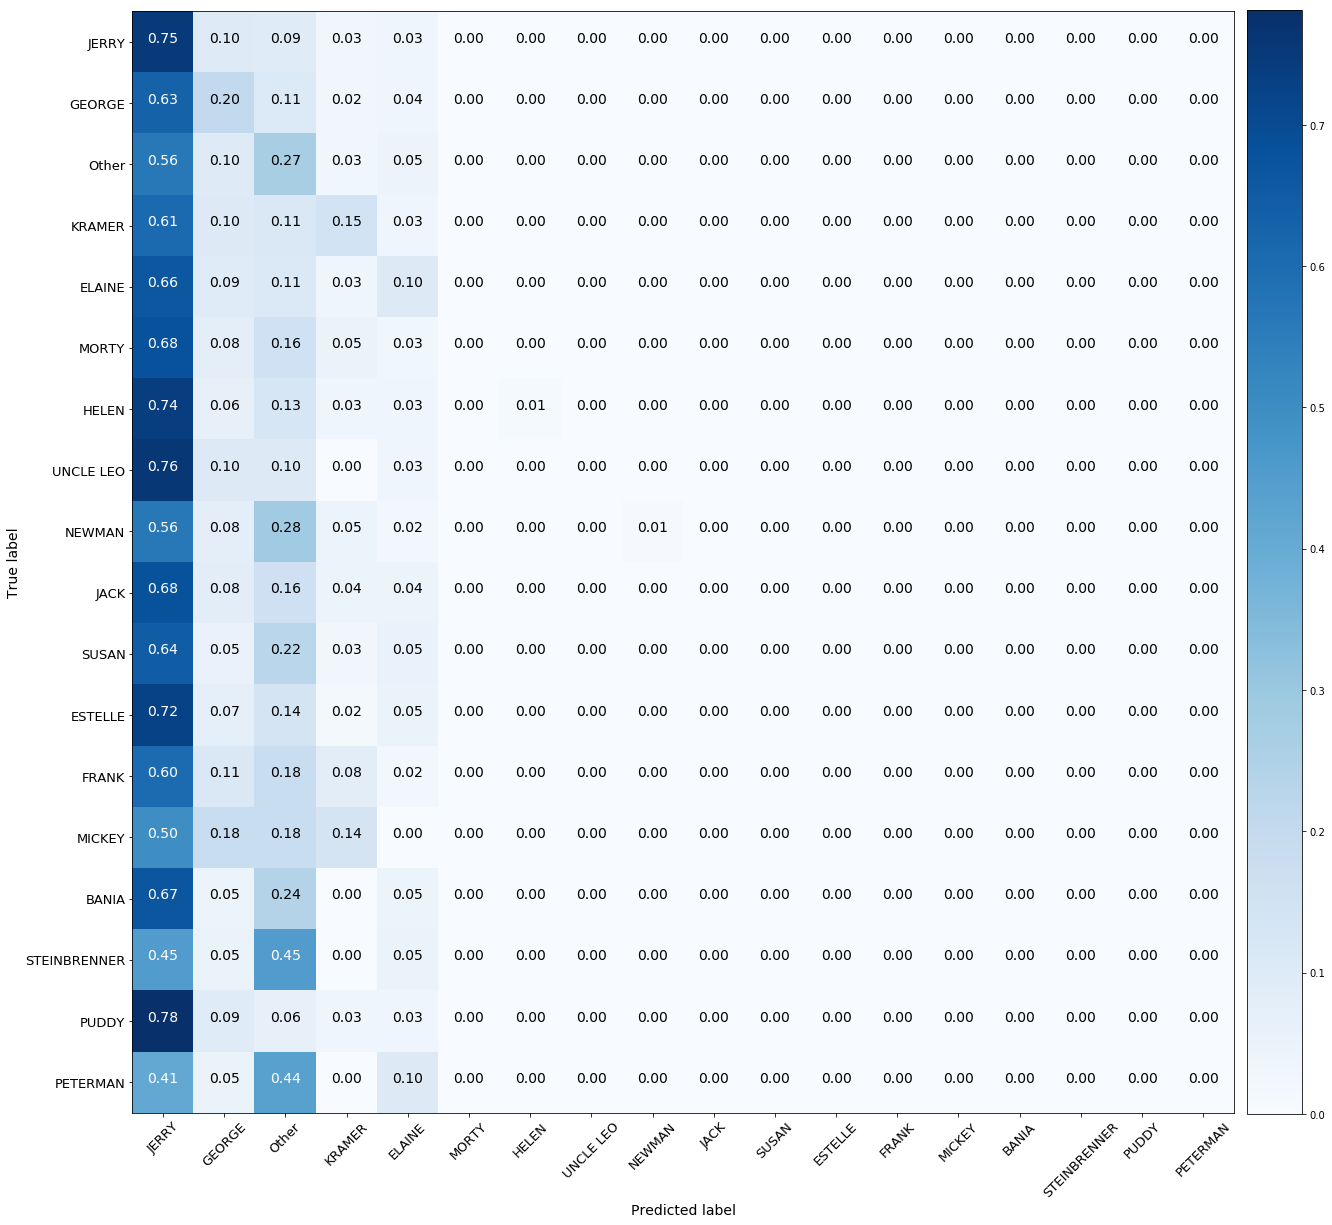

In [32]:
# create confusion map
cnf_matrix = confusion_matrix(y_test, predictions_test, labels=class_names)

# Plot non-normalized confusion matrix
#plt.figure(figsize=(20,20))
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Test data: Normalized confusion matrix')

plt.show()